In [2]:
import torch
from torch_geometric.loader import DataLoader
from data_creation import create_dataset, to_pyg_data
from models.EdgeNet import EdgeNet, NodeNet, EdgeNODE, W1W2Net, EdgeODENet
from torch.optim import Adam

c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# run only if new data is desired
ode_dim = 2
n_data = 20
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_data,10000)

dataset = []
for i in range(0,len(x_train)):

    # # put in bogus data
    # data_size = 2*ode_dim*n_data
    # x_train[i][:data_size] = torch.rand(data_size)
    
    dataset.append(to_pyg_data(x_train[i],y_train[i],ode_dim,n_data))

loader = DataLoader(dataset,batch_size=64,shuffle=True)

x_text_exact, x_test, y_test, param_test = create_dataset(ode_dim,n_data,128)

dataset = []
for i in range(0,len(x_test)):
    dataset.append(to_pyg_data(x_test[i],y_test[i],ode_dim,n_data))

test_loader = DataLoader(dataset,batch_size=128,shuffle=True)

In [20]:
model = EdgeNet(n_data, 10, ode_dim ** 2, 1)
optimizer = Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.MSELoss()  # or MSELoss for regression
reg = torch.nn.L1Loss()

train_loss = []
test_loss = []

# Training loop
for epoch in range(1000):
    model.train()

    tr_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)

        loss = criterion(out.flatten(), data.y)
        # loss = loss + 0.0001*reg(out.flatten(),0*out.flatten())
        train_loss.append(loss)

        loss.backward()
        optimizer.step()
        
        tr_loss += loss

    print(tr_loss.item())

    
    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            loss = criterion(out.flatten(), data.y)
            # print(loss.item())
            test_loss.append(loss)

986.5731811523438
968.9706420898438
938.10205078125
921.5828857421875
913.7651977539062
904.980224609375
896.8411865234375
887.2589111328125
889.839111328125
884.2683715820312
885.5735473632812
883.9124755859375
884.337646484375
883.0011596679688
886.59326171875
884.889892578125
883.1451416015625
882.7660522460938
884.3882446289062
882.7562255859375
883.96630859375
883.6455688476562
883.69580078125
882.6533203125
883.7124633789062
884.8670043945312
881.8262939453125
882.8104248046875
883.2789916992188
882.045654296875
882.0274658203125
881.2952270507812
881.8283081054688
883.9435424804688
880.7415161132812
882.2862548828125
881.4988403320312
879.974365234375
879.2059326171875
879.9127807617188
883.4268188476562
877.6294555664062
881.2028198242188
879.9248657226562
879.8223266601562
880.9656372070312
880.5076293945312
879.0679321289062
877.6585083007812
877.505126953125
878.4708251953125
877.060302734375
876.1519165039062
882.3718872070312
881.5736694335938
878.6869506835938
876.3016967

KeyboardInterrupt: 

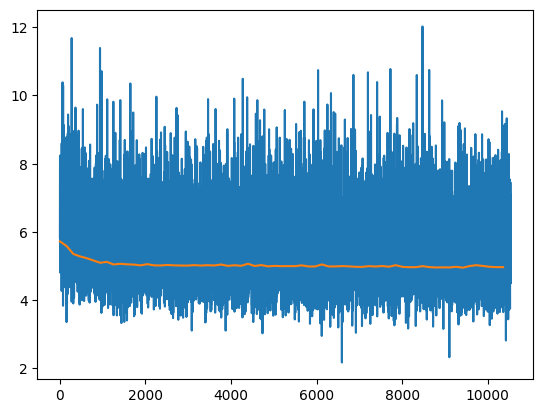

0.1
0.064
0.55375
0.53025


In [21]:
import matplotlib.pyplot as plt

def get_adjacency(W):
        values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
        treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
        W_bool_activation = (W >= torch.exp(treshold)).double()
        W_bool_repr = (W <= -torch.exp(treshold)).double()
        A = W_bool_activation-W_bool_repr
        return A

tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
tst_l = [test_loss[i].to('cpu').detach().numpy() for i in range(0,len(test_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.plot(range(0,len(loader)*len(tst_l),len(loader)),tst_l)
plt.show()

x_val_exact, x_val, y_val, param_val = create_dataset(ode_dim,n_data,1000)

val_dataset = []

for i in range(0,len(x_val)):
    val_dataset.append(to_pyg_data(x_val[i],y_val[i],ode_dim,n_data))

val_loader = DataLoader(val_dataset,batch_size=1,shuffle=True)

correct = 0
init_correct = 0
total = 0
elem_wise = 0
elem_wise_init = 0
elems_total = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k = 0
for batch in val_loader:
    Ainit = get_adjacency(batch.edge_attr.t()[0])
    Ahat = get_adjacency(model(batch)).t()[0]
    A = get_adjacency(batch.y)
    if sum(abs(Ahat-A)) < 0.001:
            correct = correct+1
    total = total + 1
    

    if sum(abs(Ainit-A)) < 0.001:
        init_correct = init_correct+1

    for i in range(0,len(A)):
        
        if abs(Ainit[i]-A[i]) < 0.001:
             elem_wise_init += 1

        if abs(Ahat[i]-A[i]) < 0.001:
             elem_wise += 1
            
        elems_total += 1

print(correct/total)
print(init_correct/total)
print(elem_wise/elems_total)
print(elem_wise_init/elems_total)